validationと同時にsubの予測も行っている

In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from pathlib import Path
import warnings
import os
import random
from tqdm.notebook import tqdm
from lightgbm import LGBMRegressor

plt.rcParams['font.family'] = "MS Gothic"
warnings.simplefilter('ignore')

In [ ]:
SAVE_DF = False
SAVE_DF_PATH = "/content/drive/MyDrive/Kaggle/花粉飛散量（ProbSpace）/proc/20221210/val24.pkl"

In [ ]:
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
fix_all_seeds(0)

# データ読み込み

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Kaggle/花粉飛散量（ProbSpace）/raw/train_v2.csv")
test = pd.read_csv("/content/drive/MyDrive/Kaggle/花粉飛散量（ProbSpace）/raw/test_v2.csv")
sub = pd.read_csv("/content/drive/MyDrive/Kaggle/花粉飛散量（ProbSpace）/raw/sample_submission.csv")

df_total_pollen = pd.read_pickle("/content/drive/MyDrive/Kaggle/花粉飛散量（ProbSpace）/proc/20230108_total_pollen_mod.pkl")
df_sunset = pd.read_pickle("/content/drive/MyDrive/Kaggle/花粉飛散量（ProbSpace）/proc/20221210/20220108_sunset.pkl")

In [ ]:
# 特徴抽出に使うcurve_fitの係数(curve_fitのノートブックから)
dict_coef = {
    "utsunomiya": [-6.0015, -0.0072],
    "tokyo": [-4.8301, -0.0055],
    "chiba": [-4.3753, -0.0045]
}

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12240 entries, 0 to 12239
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   datetime                  12240 non-null  int64  
 1   precipitation_utsunomiya  12240 non-null  float64
 2   precipitation_chiba       12240 non-null  float64
 3   precipitation_tokyo       12240 non-null  object 
 4   temperature_utsunomiya    12240 non-null  float64
 5   temperature_chiba         12240 non-null  object 
 6   temperature_tokyo         12240 non-null  object 
 7   winddirection_utsunomiya  12240 non-null  int64  
 8   winddirection_chiba       12240 non-null  object 
 9   winddirection_tokyo       12240 non-null  object 
 10  windspeed_utsunomiya      12240 non-null  float64
 11  windspeed_chiba           12240 non-null  object 
 12  windspeed_tokyo           12240 non-null  object 
 13  pollen_utsunomiya         12240 non-null  float64
 14  pollen

# 前処理

## 時系列の情報入れる

In [ ]:
def fetch_datetime_features(df):
    df["year"] = df["datetime"].map(lambda x: int(str(x)[:4]))
    df["month"] = df["datetime"].map(lambda x: int(str(x)[4:6]))
    df["day"] = df["datetime"].map(lambda x: int(str(x)[6:8]))
    df["hour"] = df["datetime"].map(lambda x: int(str(x)[8:]))
    df["datetime2"] = pd.to_datetime(df[["year", "month", "day", "hour"]])
    df["date_int"] = df["datetime"].map(lambda x: int(str(x)[:8]))
    df["date"] = df["datetime2"].dt.strftime("%Y/%m/%d")

    df["dayOfYear"] = df["datetime2"].dt.dayofyear

    # 日付をindexにする
    df.set_index("datetime2", inplace=True)
    return df

train = fetch_datetime_features(train)
test = fetch_datetime_features(test)

print("train:", train.shape)
print("test:", test.shape)
train.tail()

train: (12240, 23)
test: (336, 23)


,datetime,precipitation_utsunomiya,precipitation_chiba,precipitation_tokyo,temperature_utsunomiya,temperature_chiba,temperature_tokyo,winddirection_utsunomiya,winddirection_chiba,winddirection_tokyo,...,pollen_utsunomiya,pollen_chiba,pollen_tokyo,year,month,day,hour,date_int,date,dayOfYear
datetime2,,,,,,,,,,,,,,,,,,,,,
2020-03-31 20:00:00,2020033120,0.0,0.0,0,10.0,11.5,9.4,16,2,16,...,8.0,8.0,4.0,2020,3,31,20,20200331,2020/03/31,91
2020-03-31 21:00:00,2020033121,0.0,0.0,0,10.1,11.3,8.9,15,15,14,...,8.0,4.0,4.0,2020,3,31,21,20200331,2020/03/31,91
2020-03-31 22:00:00,2020033122,0.0,0.0,0,9.8,11.3,8.8,3,15,15,...,0.0,4.0,0.0,2020,3,31,22,20200331,2020/03/31,91
2020-03-31 23:00:00,2020033123,0.5,0.0,0,9.7,10.9,8.9,16,16,1,...,0.0,0.0,0.0,2020,3,31,23,20200331,2020/03/31,91
2020-04-01 00:00:00,2020033124,0.0,0.0,0,9.7,10.7,8.9,16,1,16,...,0.0,8.0,0.0,2020,3,31,24,20200331,2020/04/01,92


In [ ]:
test.head()

,datetime,precipitation_utsunomiya,precipitation_chiba,precipitation_tokyo,temperature_utsunomiya,temperature_chiba,temperature_tokyo,winddirection_utsunomiya,winddirection_chiba,winddirection_tokyo,...,pollen_utsunomiya,pollen_chiba,pollen_tokyo,year,month,day,hour,date_int,date,dayOfYear
datetime2,,,,,,,,,,,,,,,,,,,,,
2020-04-01 01:00:00,2020040101,0.0,0.0,0.0,9.5,10.5,9.0,14,2,14,...,0,0,0,2020,4,1,1,20200401,2020/04/01,92
2020-04-01 02:00:00,2020040102,0.0,0.0,0.0,9.2,10.3,9.0,2,16,14,...,0,0,0,2020,4,1,2,20200401,2020/04/01,92
2020-04-01 03:00:00,2020040103,0.0,0.0,0.0,9.2,10.2,9.1,16,16,12,...,0,0,0,2020,4,1,3,20200401,2020/04/01,92
2020-04-01 04:00:00,2020040104,0.0,0.0,0.0,9.4,10.3,9.2,2,15,14,...,0,0,0,2020,4,1,4,20200401,2020/04/01,92
2020-04-01 05:00:00,2020040105,0.0,0.0,0.0,9.3,10.2,9.3,2,16,15,...,0,0,0,2020,4,1,5,20200401,2020/04/01,92


## object型の対応

In [ ]:
cols_object = [
    "precipitation_tokyo",
    "temperature_chiba",
    "temperature_tokyo",
    "winddirection_chiba",
    "winddirection_tokyo",
    "windspeed_chiba",
    "windspeed_tokyo"
]
for col in cols_object:
    train[col] = pd.to_numeric(train[col], errors = 'coerce')
    test[col] = pd.to_numeric(test[col], errors = 'coerce')
    
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12240 entries, 2017-02-01 01:00:00 to 2020-04-01 00:00:00
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   datetime                  12240 non-null  int64  
 1   precipitation_utsunomiya  12240 non-null  float64
 2   precipitation_chiba       12240 non-null  float64
 3   precipitation_tokyo       12238 non-null  float64
 4   temperature_utsunomiya    12240 non-null  float64
 5   temperature_chiba         12237 non-null  float64
 6   temperature_tokyo         12237 non-null  float64
 7   winddirection_utsunomiya  12240 non-null  int64  
 8   winddirection_chiba       12237 non-null  float64
 9   winddirection_tokyo       12237 non-null  float64
 10  windspeed_utsunomiya      12240 non-null  float64
 11  windspeed_chiba           12237 non-null  float64
 12  windspeed_tokyo           12237 non-null  float64
 13  pollen_utsunomiya         

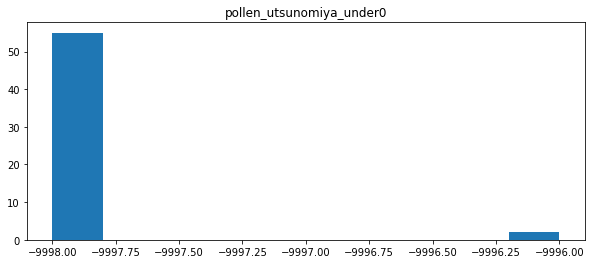

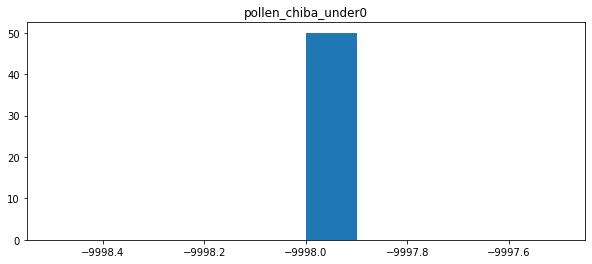

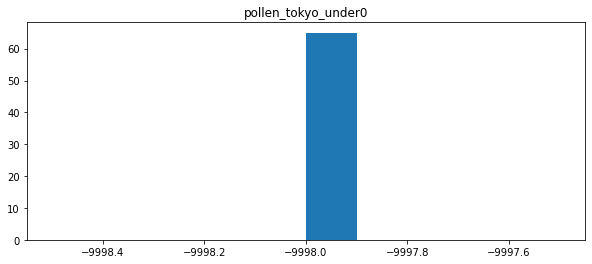

In [ ]:
objectives = [
    "pollen_utsunomiya",
    "pollen_chiba",
    "pollen_tokyo"
]

for col in objectives:
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.hist(train.loc[train[col]<0, col])
    ax.set_title(f"{col}_under0")
    plt.show()

In [ ]:
# # 降雪かつ他の地域での飛散量も0以下の時0を代入
target_col = ['pollen_utsunomiya', 'pollen_chiba', 'pollen_tokyo']
train.loc[((train['pollen_utsunomiya']==-9998)|(train['pollen_chiba']==-9998)|(train['pollen_tokyo']==-9998))&\
          (((train['pollen_utsunomiya']<=0)&(train['pollen_chiba']<=0)&(train['pollen_tokyo']<=0))), target_col] = 0

# 花粉飛散量がマイナスのやつはnanにする
train.loc[train["pollen_utsunomiya"]<0, "pollen_utsunomiya"] = np.nan
train.loc[train["pollen_chiba"]<0, "pollen_chiba"] = np.nan
train.loc[train["pollen_tokyo"]<0, "pollen_tokyo"] = np.nan

train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12240 entries, 2017-02-01 01:00:00 to 2020-04-01 00:00:00
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   datetime                  12240 non-null  int64  
 1   precipitation_utsunomiya  12240 non-null  float64
 2   precipitation_chiba       12240 non-null  float64
 3   precipitation_tokyo       12238 non-null  float64
 4   temperature_utsunomiya    12240 non-null  float64
 5   temperature_chiba         12237 non-null  float64
 6   temperature_tokyo         12237 non-null  float64
 7   winddirection_utsunomiya  12240 non-null  int64  
 8   winddirection_chiba       12237 non-null  float64
 9   winddirection_tokyo       12237 non-null  float64
 10  windspeed_utsunomiya      12240 non-null  float64
 11  windspeed_chiba           12237 non-null  float64
 12  windspeed_tokyo           12237 non-null  float64
 13  pollen_utsunomiya         

## 花粉飛散量の調整

In [ ]:
# カーブフィッティングで求めた2020年の総飛散量予測値をもとに、
# 2017~2019年の飛散量を2020年の水準に合わせる
for year in [2017, 2018, 2019]:
    for col in target_col:
        district = col[7:]
        total_pollen = df_total_pollen.at[year, district]
        total_pollen_2020 = df_total_pollen.at[2020, district]
        mod_ratio = total_pollen_2020 / total_pollen
        train.loc[train["year"]==year, col] *= mod_ratio
        print(col + " & " + str(year),  train.loc[train["year"]==year, col].sum())
    print("###"*10)

pollen_utsunomiya & 2017 46333.46459269953
pollen_chiba & 2017 32599.666704763426
pollen_tokyo & 2017 24430.515422909448
##############################
pollen_utsunomiya & 2018 46333.464592699536
pollen_chiba & 2018 32599.666704763426
pollen_tokyo & 2018 24430.51542290944
##############################
pollen_utsunomiya & 2019 46333.46459269953
pollen_chiba & 2019 32599.666704763426
pollen_tokyo & 2019 24430.51542290944
##############################


## 対数変換(precipitation, pollen)


In [ ]:
log_cols = [
    "precipitation_utsunomiya",
    "precipitation_chiba",
    "precipitation_tokyo",
    "pollen_utsunomiya",
    "pollen_chiba",
    "pollen_tokyo"
]

for col in log_cols:
    if "pollen" in col:
        train[f"log_{col}"] = np.log1p(train[col]/4)
        test[f"log_{col}"] = np.log1p(test[col]/4)
    
    else:
        train[f"log_{col}"] = np.log1p(train[col])
        test[f"log_{col}"] = np.log1p(test[col])

## Clip

In [ ]:
def _clipping_train(df, col, low_lim=0.01):
    p01 = df[col].quantile(low_lim)
    p99 = df[col].quantile(1-low_lim)
    df[col] = np.clip(df[col], p01, p99)
    return p01, p99, df

def clip_features_train(df, cols_list):
    df_clipping = pd.DataFrame(columns=["low_lim", "high_lim"])
    for col in cols_list:
        p01, p99, df = _clipping_train(df, col)
        df_clipping.loc[col] = [p01, p99]
    return df, df_clipping

def clip_features_test(df, df_df_clipping):
    cols = df_df_clipping.index.values
    low_lims = df_df_clipping["low_lim"].values
    high_lims = df_df_clipping["high_lim"].values
    for i in range(len(cols)):
        df[cols[i]] = np.clip(df[cols[i]],
                                 low_lims[i],
                                 high_lims[i])
    return df



clip_cols = [
    "log_precipitation_utsunomiya",
    "log_precipitation_chiba",
    "log_precipitation_tokyo",
]

clip_cols += [
    "log_pollen_utsunomiya",
    "log_pollen_chiba",
    "log_pollen_tokyo"
]

train, df_clip = clip_features_train(train, clip_cols)
test = clip_features_test(test, df_clip)

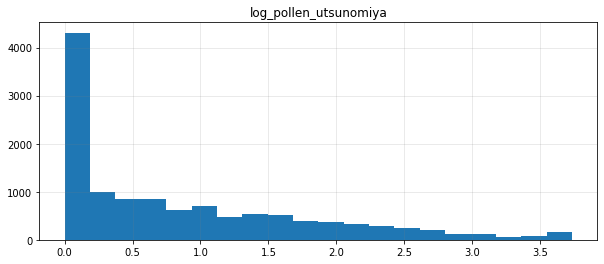

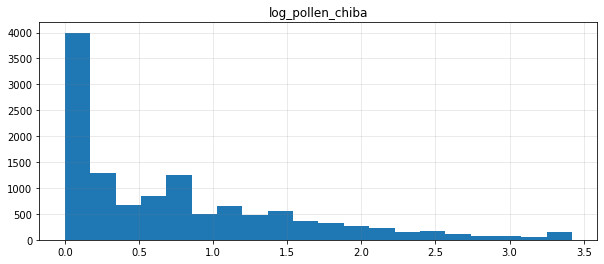

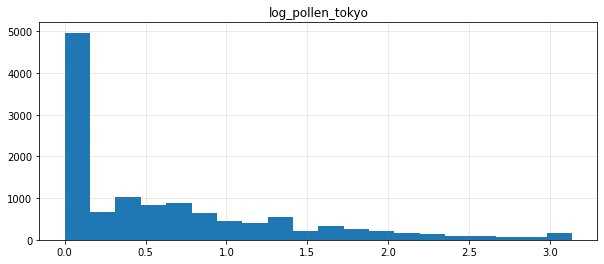

In [ ]:
objectives = [
    "log_pollen_utsunomiya",
    "log_pollen_chiba",
    "log_pollen_tokyo"
]

for col in objectives:
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.grid(alpha=0.2, color="gray")
    ax.hist(train[col], bins=20)
    ax.set_title(f"{col}")
    plt.show()

# 特徴抽出

## 風向き

In [ ]:
wind_dict_EW = {}
wind_dict_NS = {}
for i in range(0, 17):
    if i == 0:
        wind_dict_EW[i] = 0
        wind_dict_NS[i] = 0
    else:
        wind_dict_EW[i] = np.sin(np.radians(360*i/16))
        wind_dict_NS[i] = np.sin(np.radians(360*(i+4)/16))

wind_d_cols = [
    "winddirection_utsunomiya",
    "winddirection_chiba",
    "winddirection_tokyo",
]

wind_s_cols = [
    "windspeed_utsunomiya",
    "windspeed_chiba",
    "windspeed_tokyo",
]

features_wind = []
for col_d, col_s in zip(wind_d_cols, wind_s_cols):
    train[f"{col_d}_EW"] = train[col_d].replace(wind_dict_EW)
    train[f"{col_d}_NS"] = train[col_d].replace(wind_dict_NS)
    train[f"{col_s}_EW"] = train[col_s] * train[f"{col_d}_EW"]
    train[f"{col_s}_NS"] = train[col_s] * train[f"{col_d}_NS"]

    test[f"{col_d}_EW"] = test[col_d].replace(wind_dict_EW)
    test[f"{col_d}_NS"] = test[col_d].replace(wind_dict_NS)
    test[f"{col_s}_EW"] = test[col_s] * test[f"{col_d}_EW"]
    test[f"{col_s}_NS"] = test[col_s] * test[f"{col_d}_NS"]
    
    features_wind += [
        # f"{col_d}_EW",
        # f"{col_d}_NS", 
        f"{col_s}_EW", 
        f"{col_s}_NS"
    ]
    # features_wind += [f"{col_d}_EW", f"{col_d}_NS"]

## 公開されていた降水量の特徴量

In [ ]:
train_2017 = train[train["year"]==2017]
train_2018 = train[train["year"]==2018]
train_2019 = train[train["year"]==2019]
train_test_2020 = pd.concat((train[train["year"]==2020], test)).sort_index()
list_train = [
    train_2017,
    train_2018,
    train_2019,
    train_test_2020
]
print(len(train_2018))

3600


In [ ]:
# Ref : https://comp.probspace.com/competitions/pollen_counts/discussions/saru_da_mon-Post5943fd8142f960c070d7
def zero_count(input_df, alpha = 0.01):
    df_count = []
    n_count = 0
    for i in range(len(input_df)):
        if input_df[i] < 0.5:
            n_count += 1
        else:
            n_count = 0
        df_count.append(n_count)
    df_count = np.log1p(df_count)
    p01, p99 = np.quantile(df_count, q=[0, 0.9])
    df_count_clipped = np.clip(df_count, p01, p99)
    # df_count = np.tanh(np.array(df_count)*alpha)
    return df_count_clipped

# 降水量の変換
ppt_col = ['precipitation_utsunomiya', 'precipitation_chiba', 'precipitation_tokyo']
features_add2 = []
for df in list_train:
    for col in ppt_col:
        tmp = df[col].interpolate()
        df[f"zerocount_{col}"] = zero_count(tmp)
        features_add2.append(f"zerocount_{col}")
features_add2 = list(set(features_add2))

## 過去24時間の最高気温(or最低気温)と現気温の差

In [ ]:
temp_cols = ["temperature_utsunomiya", "temperature_chiba", "temperature_tokyo"]
for df in list_train:
    for col in temp_cols:
        tmp = df[["date_int", col]]
        tmp[col] = tmp[col].interpolate()
        # df[f"minmax_{col}"] = tmp.groupby("date_int")[col].transform("max") - tmp.groupby("date_int")[col].transform("min")
        df[f"minmax_{col}"] = tmp[col] - tmp[col].rolling(24).min()
        df[f"maxmin_{col}"] = tmp[col] - tmp[col].rolling(24).max()
        # df[f"argmax_{col}"] = tmp.groupby("date_int")[col].transform(lambda x: np.argmax(x.values))
        # df[f"argmin_{col}"] = tmp.groupby("date_int")[col].transform(lambda x: np.argmin(x.values))
        features_add2.append(f"minmax_{col}")
        features_add2.append(f"maxmin_{col}")
        # features_add2.append(f"argmax_{col}")
        # features_add2.append(f"argmin_{col}")
features_add2 = list(set(features_add2))

## 平均気温の累積

In [ ]:
def sigmoid_in_paper(x, a, b):
    y = 100 * np.exp(a * np.exp(b * x))
    return y

temp_cols = ["temperature_utsunomiya", "temperature_chiba", "temperature_tokyo"]
for _ in range(len(list_train)):
    df = list_train.pop(0)
    df.reset_index(inplace=True)
    for col in temp_cols:
        district = col[12:]
        total_pollen_2020 = df_total_pollen.at[2020, district]
        tmp = df[["date_int", col]].copy()
        tmp[col] = tmp[col].interpolate()
        tmp = tmp.groupby("date_int")[[col]].mean().reset_index()
        tmp[f"cumsum_{col}"] = tmp[col].cumsum()
        tmp[f"MA3_cumsum_{col}"] = tmp[f"cumsum_{col}"].rolling(3).mean()
        tmp[f"diffMA3_cumsum_{col}"] = tmp[f"cumsum_{col}"] - tmp[f"MA3_cumsum_{col}"]
        tmp[f"shiftRatio_diffMA3_cumsum_{col}"] = tmp[f"diffMA3_cumsum_{col}"] / tmp[f"diffMA3_cumsum_{col}"].shift(3)
        # Curve fittingによる1日当たりの飛散量予測量も加える
        a, b = dict_coef[district]
        tmp[f"cumsum_pollen_ratio_fitted_{district}"] = sigmoid_in_paper(tmp[f"cumsum_{col}"].values, a, b)
        tmp[f"diff1_cumsum_pollen_ratio_fitted_{district}"] = tmp[f"cumsum_pollen_ratio_fitted_{district}"].diff() * total_pollen_2020

        use_cols = [
            f"cumsum_{col}",
            f"diff1_cumsum_pollen_ratio_fitted_{district}",
            f"diffMA3_cumsum_{col}",
            f"shiftRatio_diffMA3_cumsum_{col}",
        ]

        df = df.merge(tmp[["date_int"] + use_cols],
                      how="left",
                      on="date_int")

        features_add2 += use_cols
    df = df.set_index("datetime2").sort_index()
    list_train.append(df)

features_add2 = list(set(features_add2))

## 移動平均（降水量）

In [ ]:
mov_cols = [
    "log_precipitation_utsunomiya",
    "log_precipitation_chiba",
    "log_precipitation_tokyo",
]
for df in list_train:
    for col in mov_cols:
        tmp = df[col].interpolate()
        df[f"MSUM12hours_{col}"] = tmp.rolling(12).sum()
        df[f"MSUM24hours_{col}"] = tmp.rolling(24).sum()
        df[f"MSUM48hours_{col}"] = tmp.rolling(48).sum()
        features_add2 += [f"MSUM12hours_{col}", f"MSUM24hours_{col}", f"MSUM48hours_{col}"]
features_add2 = list(set(features_add2))

## 過去7日間の移動平均との差（気温）

In [ ]:
mov_cols = [
    "temperature_utsunomiya",
    "temperature_chiba",
    "temperature_tokyo",
]
for df in list_train:
    for col in mov_cols:
        tmp = df[col].interpolate()
        df[f"MA7days_{col}"] = tmp - tmp.rolling(24*7).mean()
        features_add2.append(f"MA7days_{col}")
features_add2 = list(set(features_add2))

## 過去12時間の移動平均との差（風量）

In [ ]:
mov_cols = [
    "windspeed_utsunomiya",
    "windspeed_utsunomiya_NS",
    "windspeed_utsunomiya_EW",
    "windspeed_tokyo",
    "windspeed_tokyo_NS",
    "windspeed_tokyo_EW",
    "windspeed_chiba",
    "windspeed_chiba_NS",
    "windspeed_chiba_EW",
]
for df in list_train:
    for col in mov_cols:
        tmp = df[col].interpolate()
        df[f"MA18hours_{col}"] = tmp - tmp.rolling(18).mean()
        df[f"std18hours_{col}"] = tmp.rolling(18).std()
        df[f"MaxDiff18hours_{col}"] = tmp.rolling(18).max() - tmp
        df[f"MinDiff18hours_{col}"] = tmp.rolling(18).min() - tmp
        features_add2 += [
            f"MA18hours_{col}", 
            f"std18hours_{col}", 
            # f"MaxDiff18hours_{col}", 
            # f"MinDiff18hours_{col}"
        ]
features_add2 = list(set(features_add2))

## 各地の平均

In [ ]:
train = pd.concat(list_train).sort_index()

mean_cols = [
    # "log_precipitation",
    'temperature',
    "cumsum_temperature",
    'windspeed',
    "zerocount_precipitation"
]

districts = ["utsunomiya", "tokyo", "chiba"]
add_features = []
for col in mean_cols:
    use_cols = [f"{col}_{d}" for d in districts]
    train[f"mean_{col}"] = train[use_cols].mean(axis=1)
    add_features.append(f"mean_{col}")

## 日の出時間からの経過時間

In [ ]:
train = train.merge(df_sunset[["utsunomiya_rising", "utsunomiya_setting"]],
                    how="left",
                    left_on="date",
                    right_index=True)
train["seconds_since_rising"] = np.round((train.index - train["utsunomiya_rising"]).dt.total_seconds())
# train["seconds_till_setting"] = (train.index - train["utsunomiya_setting"]).dt.total_seconds()

## 使用する特徴量

In [ ]:
features = [
    # "log_precipitation_utsunomiya",
    # "log_precipitation_chiba",
    # "log_precipitation_tokyo",
    "temperature_utsunomiya",
    "temperature_chiba",
    "temperature_tokyo",
    "windspeed_utsunomiya",
    "windspeed_chiba",
    "windspeed_tokyo",
    "dayOfYear",
    "hour",
    "seconds_since_rising",
    # "seconds_till_setting"
]

all_features = features + features_wind + add_features + features_add2

print("特徴量の数:", len(all_features))
all_features

特徴量の数: 70


['temperature_utsunomiya',
 'temperature_chiba',
 'temperature_tokyo',
 'windspeed_utsunomiya',
 'windspeed_chiba',
 'windspeed_tokyo',
 'dayOfYear',
 'hour',
 'seconds_since_rising',
 'windspeed_utsunomiya_EW',
 'windspeed_utsunomiya_NS',
 'windspeed_chiba_EW',
 'windspeed_chiba_NS',
 'windspeed_tokyo_EW',
 'windspeed_tokyo_NS',
 'mean_temperature',
 'mean_cumsum_temperature',
 'mean_windspeed',
 'mean_zerocount_precipitation',
 'MA18hours_windspeed_utsunomiya_NS',
 'MSUM12hours_log_precipitation_chiba',
 'minmax_temperature_chiba',
 'MA7days_temperature_chiba',
 'MSUM48hours_log_precipitation_tokyo',
 'diffMA3_cumsum_temperature_tokyo',
 'minmax_temperature_tokyo',
 'zerocount_precipitation_tokyo',
 'std18hours_windspeed_tokyo',
 'MA18hours_windspeed_tokyo_EW',
 'MA18hours_windspeed_chiba',
 'MA18hours_windspeed_chiba_EW',
 'MA7days_temperature_utsunomiya',
 'MSUM48hours_log_precipitation_chiba',
 'zerocount_precipitation_utsunomiya',
 'MA18hours_windspeed_utsunomiya',
 'minmax_tempe

In [ ]:
if SAVE_DF:
    train.to_pickle(SAVE_DF_PATH)

## 相関が高い特徴量消す


In [ ]:
corr = train[all_features].corr()
threshold = 0.95
drop_numeric_cols=[]
pair=[]
for col in all_features:
    # if col in cat_features:
    #     continue
    for i in range(len(corr)):
        if abs(corr[col].iloc[i]) >= threshold and col != all_features[i] :
            print(f"{col} and {all_features[i]} are highly correlated...") 
            if col not in pair:
                pair.append(col)
                pair.append(all_features[i])
                drop_numeric_cols.append(col) 
all_features = list(set(all_features)-set(drop_numeric_cols))
print(f"Dropping columns : {drop_numeric_cols}")
print("特徴量の数：", len(all_features))
del drop_numeric_cols
del pair

all_features

temperature_utsunomiya and temperature_chiba are highly correlated...
temperature_utsunomiya and temperature_tokyo are highly correlated...
temperature_utsunomiya and mean_temperature are highly correlated...
temperature_chiba and temperature_utsunomiya are highly correlated...
temperature_chiba and temperature_tokyo are highly correlated...
temperature_chiba and mean_temperature are highly correlated...
temperature_tokyo and temperature_utsunomiya are highly correlated...
temperature_tokyo and temperature_chiba are highly correlated...
temperature_tokyo and mean_temperature are highly correlated...
dayOfYear and mean_cumsum_temperature are highly correlated...
dayOfYear and cumsum_temperature_utsunomiya are highly correlated...
dayOfYear and cumsum_temperature_chiba are highly correlated...
dayOfYear and cumsum_temperature_tokyo are highly correlated...
mean_temperature and temperature_utsunomiya are highly correlated...
mean_temperature and temperature_chiba are highly correlated...


['windspeed_utsunomiya',
 'MA7days_temperature_chiba',
 'minmax_temperature_tokyo',
 'zerocount_precipitation_tokyo',
 'MA18hours_windspeed_tokyo_EW',
 'MA18hours_windspeed_chiba',
 'MSUM48hours_log_precipitation_chiba',
 'temperature_chiba',
 'std18hours_windspeed_utsunomiya',
 'MSUM24hours_log_precipitation_utsunomiya',
 'MSUM12hours_log_precipitation_tokyo',
 'windspeed_tokyo_EW',
 'MA18hours_windspeed_chiba_NS',
 'std18hours_windspeed_tokyo_EW',
 'MA7days_temperature_tokyo',
 'std18hours_windspeed_tokyo_NS',
 'seconds_since_rising',
 'windspeed_utsunomiya_EW',
 'MSUM48hours_log_precipitation_utsunomiya',
 'std18hours_windspeed_chiba_EW',
 'mean_zerocount_precipitation',
 'std18hours_windspeed_utsunomiya_NS',
 'windspeed_tokyo_NS',
 'MA18hours_windspeed_tokyo',
 'shiftRatio_diffMA3_cumsum_temperature_utsunomiya',
 'windspeed_utsunomiya_NS',
 'shiftRatio_diffMA3_cumsum_temperature_tokyo',
 'std18hours_windspeed_chiba_NS',
 'windspeed_chiba',
 'MA18hours_windspeed_utsunomiya_NS',
 'MS

# CV

In [ ]:
def my_kfold(df):
    idx = df.index
    cv = []
    train_idx1 = (idx < dt.datetime(2018, 4, 1))
    val_idx1 = (idx >= dt.datetime(2018, 4, 1))&\
               (idx < dt.datetime(2018, 4, 15))
    cv.append([train_idx1, val_idx1])
    train_idx2 = (idx < dt.datetime(2018, 4, 15))
    val_idx2 = (idx >= dt.datetime(2018, 4, 15))&\
               (idx < dt.datetime(2018, 4, 29))
    cv.append([train_idx2, val_idx2])
    train_idx3 = (idx < dt.datetime(2019, 4, 1))
    val_idx3 = (idx >= dt.datetime(2019, 4, 1))&\
               (idx < dt.datetime(2019, 4, 15))
    cv.append([train_idx3, val_idx3])
    train_idx4 = (idx < dt.datetime(2019, 4, 15))
    val_idx4 = (idx >= dt.datetime(2019, 4, 15))&\
               (idx < dt.datetime(2019, 4, 29))
    cv.append([train_idx4, val_idx4])
    # validationと同時にsub部分の予測もする。
    train_for_sub_idx = (idx < dt.datetime(2020, 4, 1, 1))
    sub_idx = (idx >= dt.datetime(2020, 4, 1, 1))  # 使ってない
    cv.append([train_for_sub_idx, sub_idx])
    return cv

In [ ]:
# https://www.kaggle.com/code1110/gresearch-simple-lgb-starter
def my_cross_val_predict(df, y_name=None, y_raw_name=None, cv=None, params=None, features=None, sub=None):
    results_mae = []
    dict_learning_rate = {}
    fi_df = pd.DataFrame()
    fi_df['features'] = features
    for i, (train_idx, val_idx) in enumerate(cv):
        df_train = df.iloc[train_idx].copy()
        X_train = df_train[features].values
        y_train = df_train[y_name].values

        df_val = df.iloc[val_idx].copy()
        X_val = df_val[features].values
        y_val = df_val[y_name].values
        y_val_raw = df_val[y_raw_name].values

        train_dataset = lgb.Dataset(X_train,
                                    y_train,
                                    feature_name=features,)
        val_dataset = lgb.Dataset(X_val,
                                  y_val,
                                  feature_name=features,)
        
        ### testの予測（sub用）###
        if i == len(cv)-1:
            model = lgb.train(params=params,
                              train_set=train_dataset,)
            y_pred_raw = model.predict(X_val)
            y_pred = np.expm1(y_pred_raw)
            y_pred[y_pred<0] = 0
            y_pred = np.round(y_pred) * 4
            sub[y_raw_name] = y_pred
            break
        ##########################

        evals_result = {}
        callbacks = [
            # lgb.log_evaluation(100),
            # lgb.early_stopping(500),
            lgb.record_evaluation(evals_result)
        ]

        model = lgb.train(params=params,
                          train_set=train_dataset,
                          valid_sets=[val_dataset],
                          callbacks=callbacks,
                          verbose_eval=100,)
        y_pred_raw = model.predict(X_val)
        y_pred = np.expm1(y_pred_raw)
        y_pred[y_pred<0] = 0
        y_pred = np.round(y_pred) * 4
        # y_pred = y_pred*4
        # y_pred[y_pred<4] = 0

        fig, ax = plt.subplots()
        ax.grid(alpha=0.2)
        ax.scatter(y_pred, y_val_raw, s=2)
        ax.set_xlabel("Pred")
        ax.set_ylabel("True")
        ax.set_title(f"val_{i}")
        plt.show()

        mae = np.mean(np.abs(y_val_raw - y_pred))
        results_mae.append(mae)
        fi_df[f"importance_cv{i}"] = model.feature_importance(importance_type='gain')
        dict_learning_rate[f"fold_{i}"] = np.array(evals_result['valid_0']['fair'])
        
    fig, ax = plt.subplots()
    ax.grid(alpha=0.2)
    for key, value in dict_learning_rate.items():
        x = list(range(len(value)))
        ax.plot(x, value, label=key)
    ax.legend(loc="upper left", bbox_to_anchor=(1, 0.5))
    # ax.set_ylim([-0.05, 0.2])
    plt.show()

    return results_mae, fi_df, sub

In [ ]:
def plot_results(results):
    x_list = [f"cv{i}" for i in range(4)]
    fig = plt.figure(figsize=(7, 4))
    ax = fig.add_subplot()
    ax.bar(x=x_list, height=results, label="MAE", zorder=10)
    ax.set_ylabel("MAE")
    # ax.set_ylim([0, 0.007])
    ax.grid(zorder=-10)
    ax.legend()
    plt.show()

# from: https://blog.amedama.jp/entry/lightgbm-cv-feature-importance
def plot_importance(fi_df, figsize=(10, 10)):
#     raw_importances = cvbooster.feature_importance(importance_type='gain')
    feature_name = fi_df.features.to_list()
    importance_df = pd.DataFrame(data=fi_df.iloc[:, 1:].values.T,
                             columns=feature_name)
    # 平均値でソートする
    sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    print(sorted_importance_df.shape)
    # 上位をプロットする
#     PLOT_TOP_N = 40
    plot_cols = sorted_importance_df.columns[:80]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.show()

In [ ]:
print("Length of train (before dropna):", len(train))
train.dropna(inplace=True)
print("Length of train (after dropna):", len(train))
# 140日経過以降は花粉の飛散が無いので削る
train = train[train["dayOfYear"]<=140]
print("Length of train (finalize):", len(train))

cv_indicies = my_kfold(train)

Length of train (before dropna): 12576
Length of train (after dropna): 11856
Length of train (finalize): 8901


## 宇都宮

[100]	valid_0's fair: 0.177868
[200]	valid_0's fair: 0.169694
[300]	valid_0's fair: 0.168315
[400]	valid_0's fair: 0.168688
[500]	valid_0's fair: 0.168358
[600]	valid_0's fair: 0.168465
[700]	valid_0's fair: 0.16894


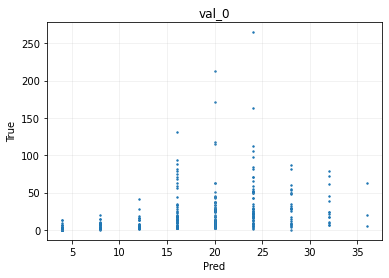

[100]	valid_0's fair: 0.0990133
[200]	valid_0's fair: 0.0936457
[300]	valid_0's fair: 0.0938528
[400]	valid_0's fair: 0.0941499
[500]	valid_0's fair: 0.0942188
[600]	valid_0's fair: 0.0940867
[700]	valid_0's fair: 0.093989


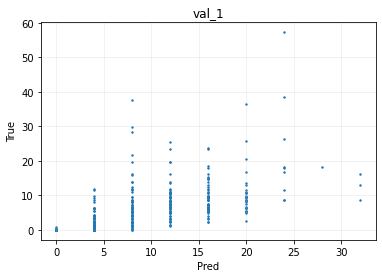

[100]	valid_0's fair: 0.176257
[200]	valid_0's fair: 0.167242
[300]	valid_0's fair: 0.164015
[400]	valid_0's fair: 0.163633
[500]	valid_0's fair: 0.16338
[600]	valid_0's fair: 0.163394
[700]	valid_0's fair: 0.163404


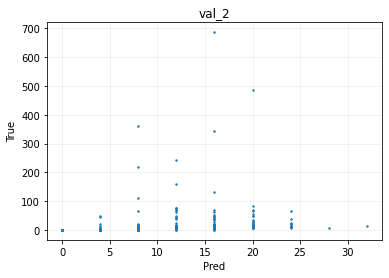

[100]	valid_0's fair: 0.111807
[200]	valid_0's fair: 0.105923
[300]	valid_0's fair: 0.104125
[400]	valid_0's fair: 0.10413
[500]	valid_0's fair: 0.104568
[600]	valid_0's fair: 0.104723
[700]	valid_0's fair: 0.104979


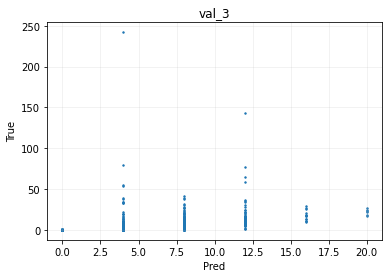

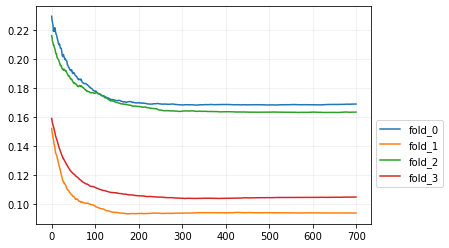

In [ ]:
params = {
        # "extra_trees": True,
    'objective': 'fair',
    'metric': 'fair',
    'boosting_type': 'gbdt',
    'max_depth': 9,
 'n_estimators': 700,
 'learning_rate': 0.01397557995522496,
 'lambda_l2': 4.611316892731575,
 'num_leaves': 167,
 'colsample_bytree': 0.41815543878285094,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 46,
}

results_u, fi_df_u, sub = my_cross_val_predict(train,
                                    "log_pollen_utsunomiya",
                                    "pollen_utsunomiya",
                                    cv=cv_indicies,
                                    params=params,
                                    features=all_features,
                                    sub=sub)

CV0: 15.90
CV1: 5.37
CV2: 16.27
CV3: 7.11


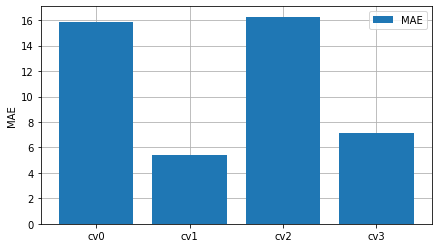

In [ ]:
for i, mae in enumerate(results_u):
    print(f"CV{i}: {mae:.2f}")
plot_results(results_u)

(4, 59)


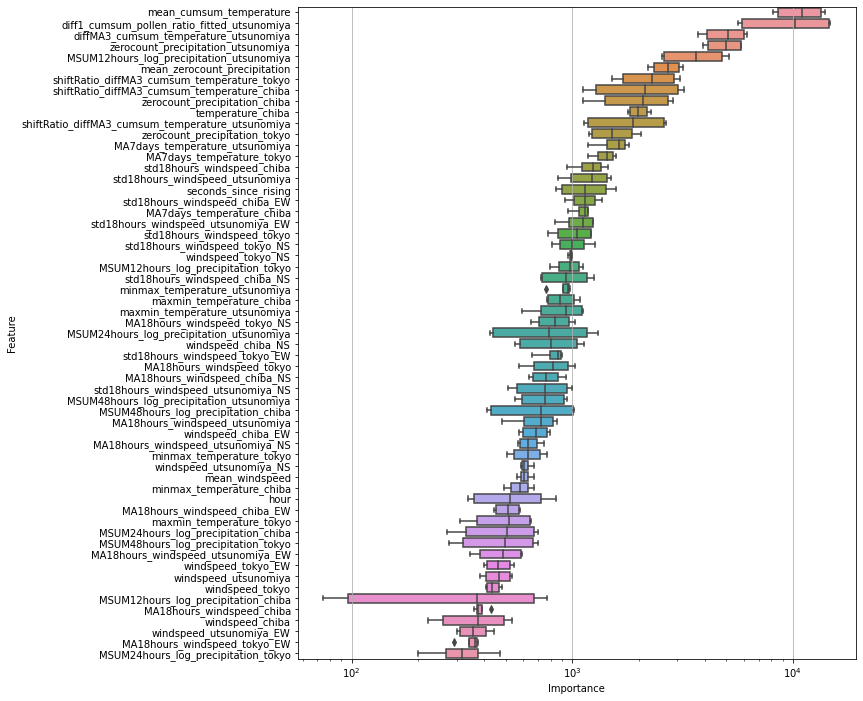

In [ ]:
plot_importance(fi_df_u, figsize=(10, 12))

## 東京

[100]	valid_0's fair: 0.180939
[200]	valid_0's fair: 0.181475
[300]	valid_0's fair: 0.181408
[400]	valid_0's fair: 0.180708
[500]	valid_0's fair: 0.178628
[600]	valid_0's fair: 0.177474


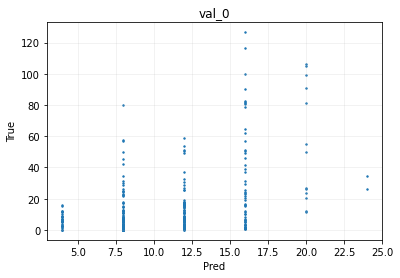

[100]	valid_0's fair: 0.108909
[200]	valid_0's fair: 0.117084
[300]	valid_0's fair: 0.121701
[400]	valid_0's fair: 0.125177
[500]	valid_0's fair: 0.127054
[600]	valid_0's fair: 0.128166


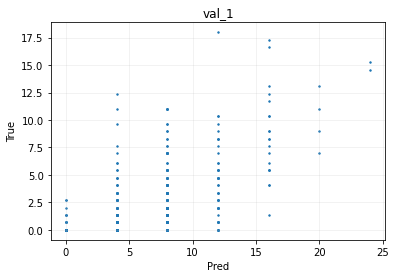

[100]	valid_0's fair: 0.121857
[200]	valid_0's fair: 0.118937
[300]	valid_0's fair: 0.118034
[400]	valid_0's fair: 0.11736
[500]	valid_0's fair: 0.117544
[600]	valid_0's fair: 0.117453


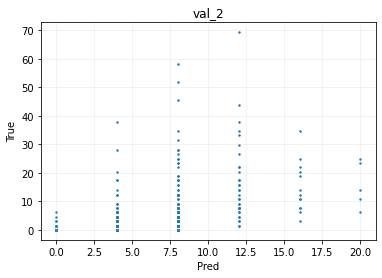

[100]	valid_0's fair: 0.0982601
[200]	valid_0's fair: 0.0954266
[300]	valid_0's fair: 0.0936114
[400]	valid_0's fair: 0.0931537
[500]	valid_0's fair: 0.0927741
[600]	valid_0's fair: 0.0926902


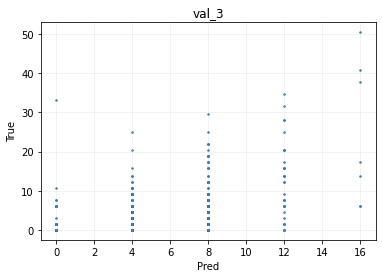

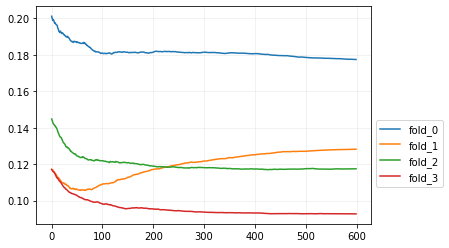

In [ ]:
params = {
        # "extra_trees": True,
    'objective': 'fair',
    'metric': 'fair',
    'boosting_type': 'gbdt',
    'max_depth': 23,
 'n_estimators': 600,
 'learning_rate': 0.009148271396819509,
 'lambda_l2': 2.4056285524139014,
 'num_leaves': 68,
 'colsample_bytree': 0.37313117665127893,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 46,
}

results_t, fi_df_t, sub = my_cross_val_predict(train,
                                    "log_pollen_tokyo",
                                    "pollen_tokyo",
                                    cv=cv_indicies,
                                    params=params,
                                    features=all_features,
                                    sub=sub)

CV0: 11.74
CV1: 4.61
CV2: 5.61
CV3: 4.48


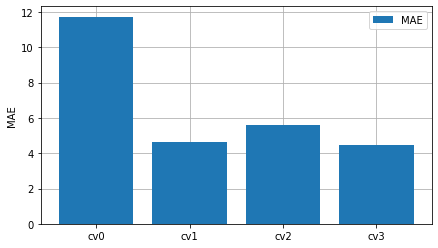

In [ ]:
for i, mae in enumerate(results_t):
    print(f"CV{i}: {mae:.2f}")
plot_results(results_t)

(4, 59)


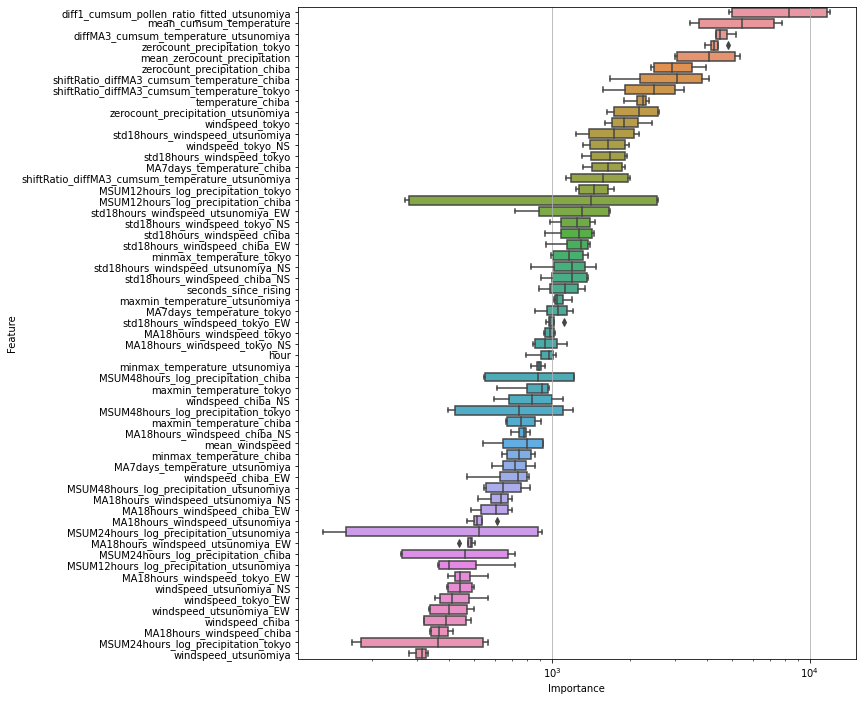

In [ ]:
plot_importance(fi_df_t, figsize=(10, 12))

## 千葉

[100]	valid_0's fair: 0.150927
[200]	valid_0's fair: 0.156206
[300]	valid_0's fair: 0.160341
[400]	valid_0's fair: 0.16287
[500]	valid_0's fair: 0.164191
[600]	valid_0's fair: 0.165353
[700]	valid_0's fair: 0.166172
[800]	valid_0's fair: 0.166005
[900]	valid_0's fair: 0.165262
[1000]	valid_0's fair: 0.165606
[1100]	valid_0's fair: 0.164252
[1200]	valid_0's fair: 0.163712


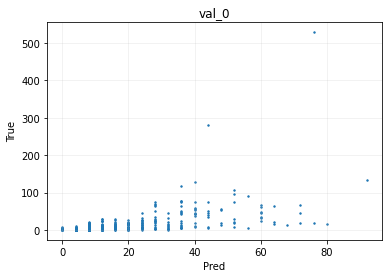

[100]	valid_0's fair: 0.0951179
[200]	valid_0's fair: 0.088051
[300]	valid_0's fair: 0.0890566
[400]	valid_0's fair: 0.0899201
[500]	valid_0's fair: 0.0902742
[600]	valid_0's fair: 0.0897555
[700]	valid_0's fair: 0.0915929
[800]	valid_0's fair: 0.0920984
[900]	valid_0's fair: 0.0927361
[1000]	valid_0's fair: 0.0932348
[1100]	valid_0's fair: 0.093652
[1200]	valid_0's fair: 0.0944529


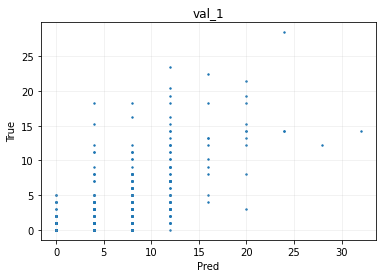

[100]	valid_0's fair: 0.136692
[200]	valid_0's fair: 0.14208
[300]	valid_0's fair: 0.139359
[400]	valid_0's fair: 0.138414
[500]	valid_0's fair: 0.140185
[600]	valid_0's fair: 0.140726
[700]	valid_0's fair: 0.140277
[800]	valid_0's fair: 0.141398
[900]	valid_0's fair: 0.141002
[1000]	valid_0's fair: 0.141345
[1100]	valid_0's fair: 0.141212
[1200]	valid_0's fair: 0.141913


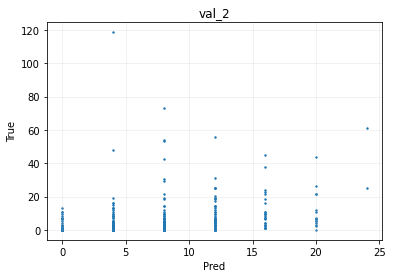

[100]	valid_0's fair: 0.108355
[200]	valid_0's fair: 0.101704
[300]	valid_0's fair: 0.0963976
[400]	valid_0's fair: 0.0930393
[500]	valid_0's fair: 0.0915687
[600]	valid_0's fair: 0.0909987
[700]	valid_0's fair: 0.0903254
[800]	valid_0's fair: 0.0899805
[900]	valid_0's fair: 0.0901964
[1000]	valid_0's fair: 0.0898322
[1100]	valid_0's fair: 0.0892623
[1200]	valid_0's fair: 0.0887888


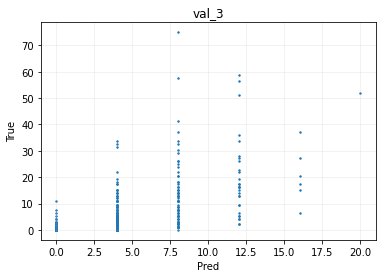

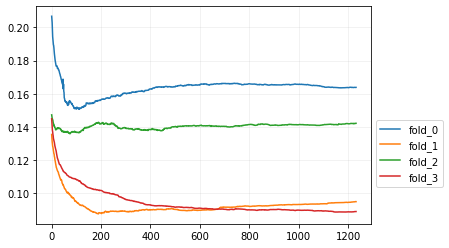

In [ ]:
params = {
        # "extra_trees": True,
    'objective': 'fair',
    'metric': 'fair',
    'boosting_type': 'gbdt',
    'max_depth': 3,
 'n_estimators': 1233,
 'learning_rate': 0.030139062254810847,
 'lambda_l2': 0.69825297208385,
 'num_leaves': 108,
 'colsample_bytree': 0.7706021026655606,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 46,
}

results_c, fi_df_c, sub = my_cross_val_predict(train,
                                    "log_pollen_chiba",
                                    "pollen_chiba",
                                    cv=cv_indicies,
                                    params=params,
                                    features=all_features,
                                    sub=sub)

CV0: 13.92
CV1: 4.00
CV2: 6.77
CV3: 5.28


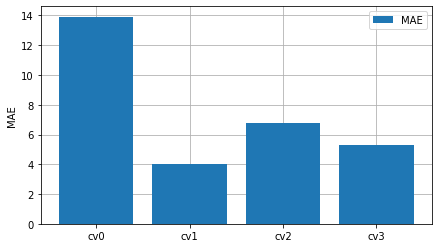

In [ ]:
for i, mae in enumerate(results_c):
    print(f"CV{i}: {mae:.2f}")
plot_results(results_c)

(4, 59)


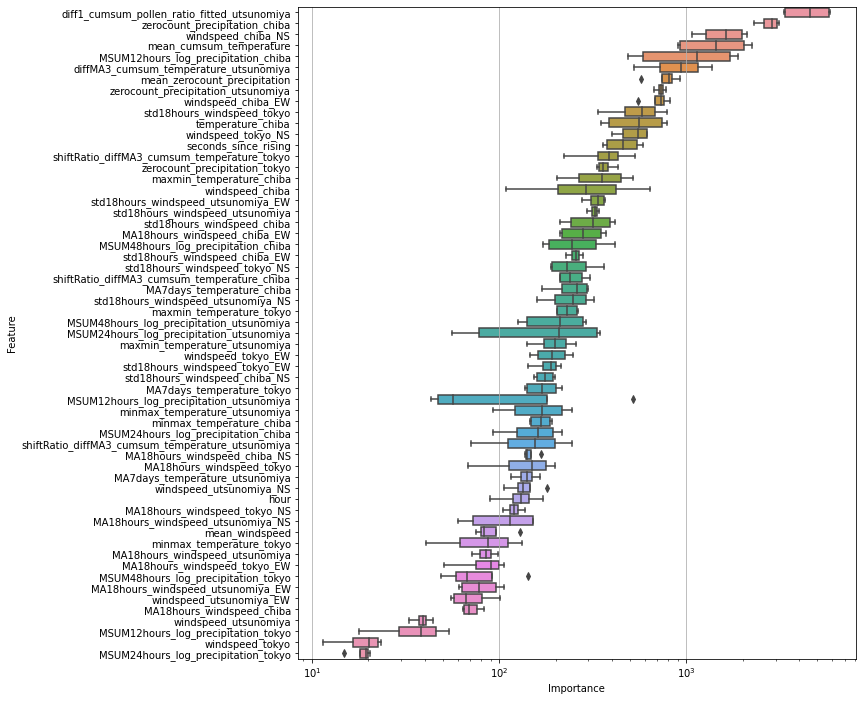

In [ ]:
plot_importance(fi_df_c, figsize=(10, 12))

# Sub確認

In [ ]:
sub

,datetime,pollen_utsunomiya,pollen_chiba,pollen_tokyo
0,2020040101,4.0,4.0,4.0
1,2020040102,4.0,4.0,4.0
2,2020040103,4.0,4.0,4.0
3,2020040104,4.0,4.0,4.0
4,2020040105,4.0,4.0,4.0
...,...,...,...,...
331,2020041420,8.0,12.0,4.0
332,2020041421,8.0,8.0,4.0
333,2020041422,4.0,8.0,4.0
334,2020041423,4.0,4.0,4.0


In [ ]:
# sub.to_csv("/content/drive/MyDrive/Kaggle/花粉飛散量（ProbSpace）/proc/20221210/sub_20230109.csv", index=False)